Source: <https://cogo-sys-data.s3.amazonaws.com/index.html> 

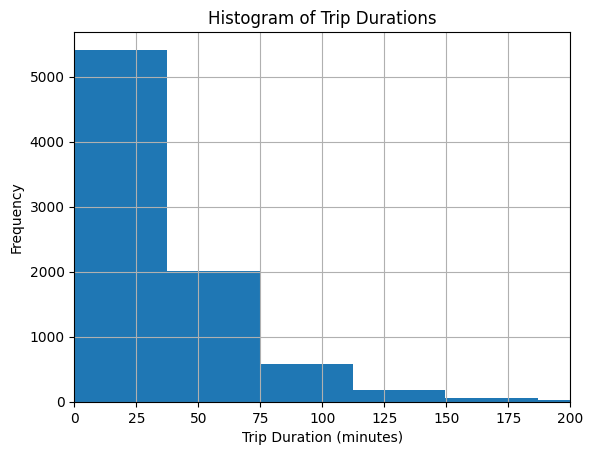

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,AC773B0F453B3EC3,docked_bike,2020-07-03 08:28:44,2020-07-03 08:58:13,High St & King Ave,50.0,High St & King Ave,50.0,39.990144,-83.005912,39.990144,-83.005912,casual,29
1,978EEF592D58099B,electric_bike,2020-07-09 20:45:20,2020-07-09 20:50:09,Wellesley Dr & Lane Ave,75.0,NaN,NaN,40.007217,-83.051720,40.010000,-83.050000,casual,4
2,875000B920DEC99E,electric_bike,2020-07-21 15:27:22,2020-07-21 15:50:45,Schiller Park - Stewart Ave,6.0,Schiller Park - Stewart Ave,6.0,39.941951,-82.994965,39.942040,-82.995022,casual,23
3,9DCDA365946975A3,electric_bike,2020-07-12 15:59:35,2020-07-12 16:36:52,Linden Transit Center,105.0,St. Stephen's Community House,103.0,39.993584,-82.981078,40.000875,-82.968266,casual,37
4,6090A9CD06C2E844,electric_bike,2020-07-11 21:42:02,2020-07-11 22:27:57,Bicentennial Park,1.0,NaN,NaN,39.955951,-83.003244,39.980000,-83.000000,casual,45


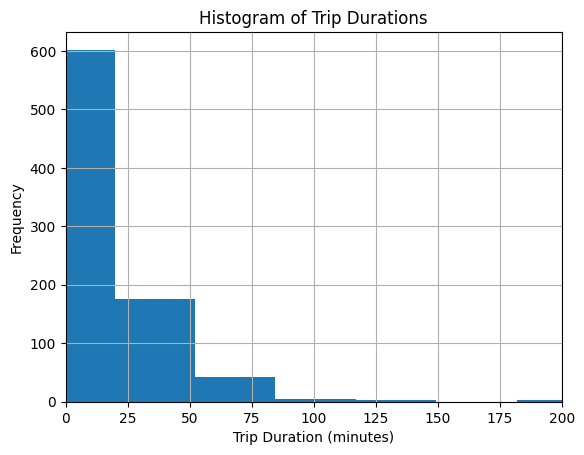

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,D4789C794D4BA844,electric_bike,2020-12-11 15:53:22,2020-12-11 16:04:02,Library - Main Branch,28.0,North Bank Park,92.0,39.961635,-82.990820,39.965058,-83.008714,casual,10
1,3EBE00D79E554A29,docked_bike,2020-12-12 16:21:10,2020-12-12 16:39:27,North Bank Park,92.0,North Bank Park,92.0,39.964999,-83.008772,39.964999,-83.008772,casual,18
2,EA1FA5B3BD56B47C,docked_bike,2020-12-12 16:21:27,2020-12-12 16:39:21,North Bank Park,92.0,North Bank Park,92.0,39.964999,-83.008772,39.964999,-83.008772,casual,17
3,98B54EEB2906C9B5,electric_bike,2020-12-13 15:35:59,2020-12-13 16:00:33,North Bank Park,92.0,North Bank Park,92.0,39.964990,-83.008797,39.965010,-83.008678,casual,24
4,4FA02E4EC5E673ED,electric_bike,2020-12-13 16:02:22,2020-12-13 16:32:19,North Bank Park,92.0,North Bank Park,92.0,39.965021,-83.008685,39.964967,-83.008612,casual,29


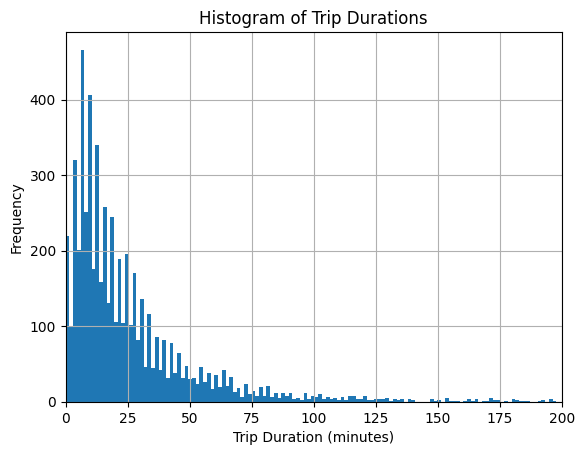

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,37C46B2159B84F8B,classic_bike,2021-07-14 12:07:08,2021-07-14 12:14:21,Northwest Blvd & Chambers Rd,94.0,Mallway Park at Arlington Ave,77.0,39.993580,-83.042214,39.998816,-83.061731,member,7
1,8CF8EE1DD8DB5B58,classic_bike,2021-07-14 16:43:34,2021-07-14 16:58:05,Grandview Ave & 3rd Ave,78.0,Kilbourne St & Vine St,21.0,39.985158,-83.044511,39.971250,-83.007537,member,14
2,970D456FD69DA4CC,classic_bike,2021-07-03 18:47:10,2021-07-03 19:09:49,High St & King Ave,50.0,High St & Crestview Rd,88.0,39.990142,-83.005829,40.022519,-83.013642,casual,22
3,1BD8C6D38853A946,electric_bike,2021-07-28 09:54:21,2021-07-28 10:05:59,Bank St & Frankfort St,8.0,City Hall,2.0,39.946555,-83.000272,39.963043,-83.004310,casual,11
4,2E3C4C8E3B054786,classic_bike,2021-07-07 10:45:21,2021-07-07 11:22:19,High St & King Ave,50.0,Library - Linden Branch,102.0,39.990142,-83.005829,40.012850,-82.968221,casual,36


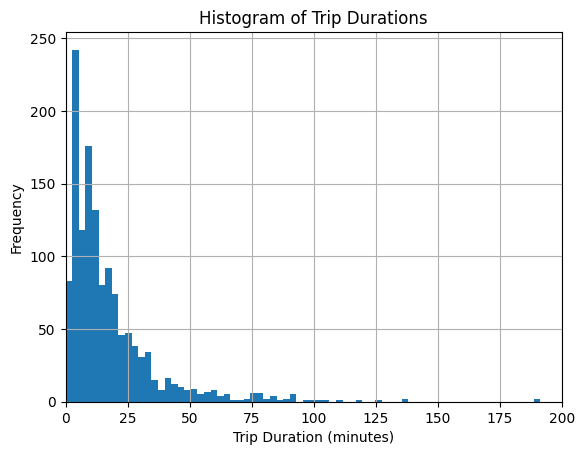

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,3DF95E61DB695C2E,classic_bike,2021-12-05 16:07:55,2021-12-05 16:26:06,North Market,20.0,North Market,20.0,39.972198,-83.003570,39.972198,-83.003570,member,18
1,DE0C04E8E0FD79F9,electric_bike,2021-12-31 13:55:22,2021-12-31 14:04:49,North Market,20.0,Front St & Town St,82.0,39.972203,-83.003615,39.959074,-83.001959,casual,9
2,7B0C642F26036460,classic_bike,2021-12-31 13:55:00,2021-12-31 14:04:40,North Market,20.0,Front St & Town St,82.0,39.972198,-83.003570,39.959074,-83.001959,casual,9
3,860BFBDFD9405614,classic_bike,2021-12-16 00:24:28,2021-12-16 00:49:08,North Market,20.0,High St & Lane Ave,83.0,39.972198,-83.003570,40.006397,-83.009192,casual,24
5,A1EC439EC1D7D77C,classic_bike,2021-12-10 19:26:47,2021-12-10 19:42:20,North Market,20.0,Columbus College of Art & Design,26.0,39.972198,-83.003570,39.965157,-82.990458,casual,15


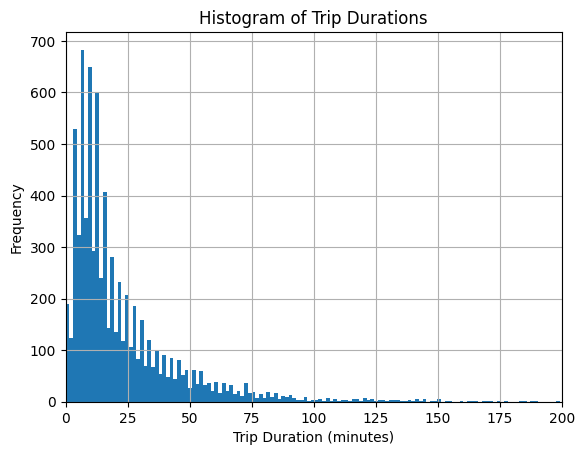

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,0089B6EA5BEDE50C,classic_bike,2022-07-14 21:34:51,2022-07-14 21:42:23,Lane Ave at Olentangy Trail,60.0,High St & Lane Ave,83.0,40.006583,-83.020464,40.006397,-83.009192,casual,7
1,0B3D03841E311516,classic_bike,2022-07-24 00:45:19,2022-07-24 00:57:05,Lane Ave at Olentangy Trail,60.0,High St & Lane Ave,83.0,40.006583,-83.020464,40.006397,-83.009192,casual,11
2,6E6BB158CFE15397,classic_bike,2022-07-24 00:46:08,2022-07-24 00:57:01,Lane Ave at Olentangy Trail,60.0,High St & Lane Ave,83.0,40.006583,-83.020464,40.006397,-83.009192,casual,10
3,17ABC7A38A54309E,classic_bike,2022-07-04 21:05:52,2022-07-04 21:13:54,Lane Ave at Olentangy Trail,60.0,High St & Lane Ave,83.0,40.006583,-83.020464,40.006397,-83.009192,casual,8
4,7D1BBD07AE148CD8,classic_bike,2022-07-05 19:17:20,2022-07-05 19:24:52,Lane Ave at Olentangy Trail,60.0,High St & Lane Ave,83.0,40.006583,-83.020464,40.006397,-83.009192,casual,7


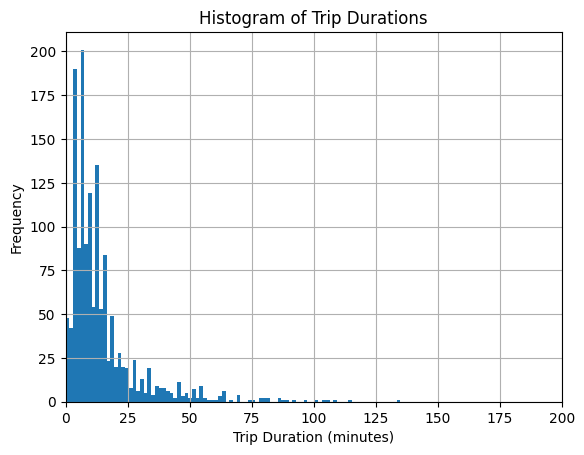

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,E5FB04C4C730BFA4,classic_bike,2022-12-30 16:58:06,2022-12-30 17:01:49,COSI,19.0,Broad St & Mc Dowell St,117.0,39.961160,-83.006485,39.960905,-83.012546,member,3
1,F1D56C3B0B5AB2B3,classic_bike,2022-12-02 17:35:03,2022-12-02 17:48:35,Neil Ave & Nationwide Blvd,7.0,High St & King Ave,50.0,39.968016,-83.008510,39.990142,-83.005829,member,13
2,62EE55B76F121568,classic_bike,2022-12-11 14:46:56,2022-12-11 14:54:21,High St & 2nd Ave,24.0,Nationwide Arena - Front St,11.0,39.982784,-83.004787,39.969172,-83.004017,member,7
3,524A519F7E1EC529,electric_bike,2022-12-15 17:07:18,2022-12-15 17:15:55,NaN,NaN,Moeller Park at Bruck St,113.0,39.950000,-82.980000,39.935897,-82.988832,casual,8
4,7E4ED66B325B706E,classic_bike,2022-12-02 16:02:35,2022-12-02 16:14:13,3rd St & Gay St,18.0,Convention Center,12.0,39.963983,-82.998648,39.971255,-83.002202,casual,11


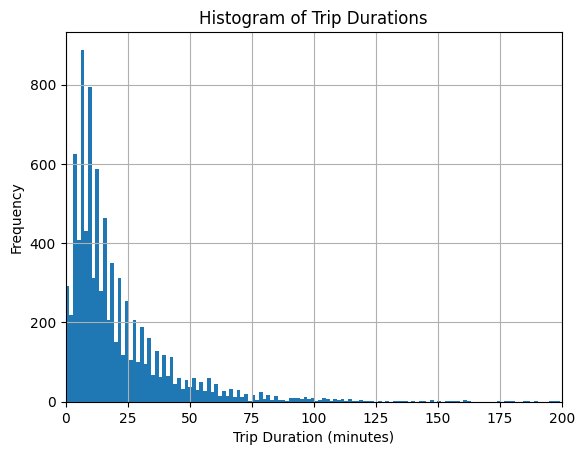

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,6F96D2605B954C24,electric_bike,2023-07-22 12:15:21,2023-07-22 12:15:49,Library - Main Branch,28.0,Library - Main Branch,28.0,39.961507,-82.990818,39.961557,-82.990844,member,0
1,165832D8C7903BF1,classic_bike,2023-07-20 20:50:19,2023-07-20 21:01:36,High St & Spring St,17.0,Schiller Park - Stewart Ave,6.0,39.965888,-83.001536,39.941996,-82.995018,member,11
2,72DF2B4B3A0AEBAC,classic_bike,2023-07-17 16:37:44,2023-07-17 16:52:23,High St & Spring St,17.0,Schiller Park - Stewart Ave,6.0,39.965888,-83.001536,39.941996,-82.995018,member,14
4,D1D195B1F06FDE45,classic_bike,2023-07-29 17:21:43,2023-07-29 18:02:38,Library - Whetstone Branch,110.0,Library - Whetstone Branch,110.0,40.041222,-83.019052,40.041222,-83.019052,member,40
5,0C0B900222EDF707,classic_bike,2023-07-08 10:27:56,2023-07-08 10:48:05,Library - Whetstone Branch,110.0,Library - Whetstone Branch,110.0,40.041222,-83.019052,40.041222,-83.019052,member,20


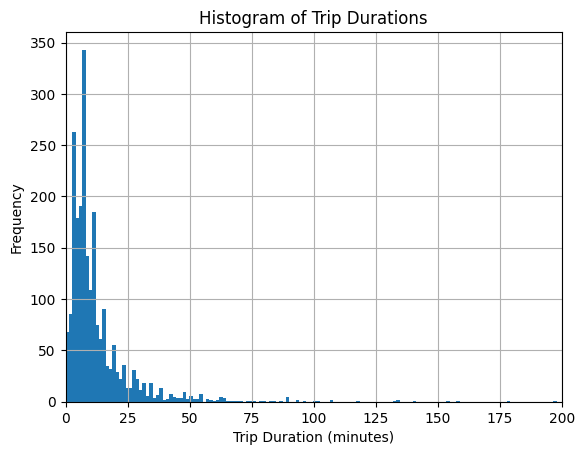

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration [min]
0,D2FB6DDDAE499FD8,electric_bike,2023-12-02 14:30:07,2023-12-02 14:38:35,Neil Ave & Buttles Ave,22.0,High St & Broad St,13.0,39.977396,-83.011585,39.962012,-83.001122,member,8
1,23CCAB27034FE6EE,electric_bike,2023-12-11 09:12:47,2023-12-11 09:20:33,Neil Ave & Buttles Ave,22.0,High St & Broad St,13.0,39.977474,-83.011523,39.962012,-83.001122,member,7
2,9F2C5EDFDC72CB1B,electric_bike,2023-12-04 09:43:50,2023-12-04 09:52:13,Neil Ave & Buttles Ave,22.0,High St & Broad St,13.0,39.977461,-83.011561,39.962012,-83.001122,member,8
3,CC6F089880F16CEE,electric_bike,2023-12-08 09:59:10,2023-12-08 10:07:01,Neil Ave & Buttles Ave,22.0,High St & Broad St,13.0,39.977422,-83.011591,39.962012,-83.001122,member,7
4,A2575038F7D506E5,electric_bike,2023-12-07 08:53:28,2023-12-07 09:01:26,Neil Ave & Buttles Ave,22.0,High St & Broad St,13.0,39.977308,-83.011510,39.962012,-83.001122,member,7


From a total number of 37203 entries, 1779 entries (4.782 %) have been removed.


In [15]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt

#reads in csv sources as df
path = "CoGo_Bikerental_colorado_US/original_data/"
filelist = os.listdir(path)

#creates counter for entries before and after cleaning
count_original = 0
count_clean = 0

for f in filelist:
    source = path + f
    df = pd.read_csv(source)
    
    #giving a first insight into data and count original entries
    #df.info()
    #display(df.head())
    count_original += len(df)

    #converts timestamps from str format into datetime format (required for calculation of trip duration)
    df['started_at']= pd.to_datetime(df['started_at'])
    df['ended_at']= pd.to_datetime(df['ended_at'])

    #calculates trip duration in minutes and adds value to a new attribute "trip duration"
    df["trip_duration [min]"] = ((df["ended_at"] - df["started_at"]).dt.total_seconds() / 60).astype(int) 
    
    hist_tripduration = df.hist(["trip_duration [min]"] , bins=1000)
    plt.title('Histogram of Trip Durations')
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Frequency')
    plt.xlim(left=0, right=200)  
    plt.grid(True)
    plt.show()

    #filters out trips < 10 min that end at the same coordinates as they start AND trips > 10 h AND trips having no coordinate values
    maxduration = 150
    minduration = 10
        
    df = df[~((df['trip_duration [min]'] < minduration) & (df['start_lat'] == df['end_lat']) & (df['start_lng'] == df['end_lng']))]
    df = df[df['trip_duration [min]'] < maxduration]
    df = df[~(df['start_lat'].isna() | df['start_lng'].isna() | df['end_lat'].isna() | df['end_lng'].isna())]

    #check on filtered out data
    #df_minduration = df[((df["trip_duration [min]"] < minduration) & (df['start_lat'] == df['end_lat']) & (df['start_lng'] == df['end_lng']))]
    #df_maxduration = df[df["trip_duration [min]"] >= maxduration]
    #df_nan = df[(df['start_lat'].isna() | df['start_lng'].isna() | df['end_lat'].isna() | df['end_lng'].isna())]
    #display(df_minduration.head())
    #display(df_maxduration.head())
    #display(df_nan.head()
 
    #for checking the modifications and counting total entries of cleaned data
    display(df.head())
    count_clean += len(df)

    #storing cleaned data
    output = "CoGo_Bikerental_colorado_US/cleaned_data/"
    f = "cleaned" + f
    storage = output + f 
    df.to_csv(storage)

#calculates total sum of removed entries over all datasets
removed = count_original - count_clean
share_removed = round((removed/count_original)*100, 3)

print(f"From a total number of {count_original} entries, {removed} entries ({share_removed} %) have been removed.")
